# Final
Historical samples:  
1/24/2010 through 1/24/2015, Training Sample (A)  
1/25/2015 through 1/25/2016, Validation Sample (B)  
1/26/2016 through 1/26/2017, Testing Sample (C)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.arima_model as ar
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize, least_squares
from scipy.stats import spearmanr

In [2]:
data = pd.read_excel('CMT-Final.xlsx', index_col=0)
data = data.drop(columns='1M')
data.dropna(how='all', inplace=True)

In [3]:
sample1 = data['2010-01-24':'2015-01-24']
sample2 = data['2015-01-25':'2016-01-25']
sample3 = data['2016-01-26':'2017-01-26']

## 1. Use Sample A to compute 5 cointegrated pairs of CMT rates: [2y,3y], [3y,5y], [2y,5y], [3y,7y], [5y,7y]

In [4]:
pairs = [('2Y', '3Y'), ('3Y', '5Y'), ('2Y', '5Y'), ('3Y', '7Y'), ('5Y', '7Y')]

In [5]:
def CCA_Chou_Ng(data_set):
    # data_set is pandas dataframe
    data_set = data_set - data_set.mean()
    X = data_set.shift(1).iloc[1:]  #X(t-1)
    Y = data_set.iloc[1:]
    
    # X(t) ~ M_1 + X(t-1)
    l1 = sm.OLS(Y, sm.add_constant(X)).fit()
    B = l1.params[1:]  #exclude constant term
    
    # X(t-1) ~ M_2 + X(t)
    l2 = sm.OLS(X, sm.add_constant(Y)).fit()
    A = l2.params[1:]
    
    C = A.values @ B.values
    eig_val, eig_vec = np.linalg.eig(C)
    idx = np.argsort(eig_val)[0]  # maximum
    weight = eig_vec[:, idx] / eig_vec[0, idx] 
    return weight

def construct_wspr(iter_set, sample, reg_sample=sample1):
    cca_weight = pd.DataFrame(columns=['y', 'x'])
    cca_wspr = pd.DataFrame()
    
    for idx, val in enumerate(iter_set):
        (i, j) = val    
        df = reg_sample[[i, j]]  # used to get weights
        df2 = sample[[i, j]]  # used to construct wspr
        # cca
        cca = CCA_Chou_Ng(df)
        cca_weight.loc[str(val), :] = cca
        cca_wspr.loc[:, str(val)] = df2 @ cca
    return cca_weight, cca_wspr

In [6]:
_, wspr = construct_wspr(pairs, sample1)

In [7]:
wspr.head()

,"('2Y', '3Y')","('3Y', '5Y')","('2Y', '5Y')","('3Y', '7Y')","('5Y', '7Y')"
Date,,,,,
2010-01-25,0.072214,-0.064643,0.076030,-0.179459,-0.256309
2010-01-26,0.082214,-0.058515,0.089310,-0.174396,-0.257827
2010-01-27,0.078452,-0.029156,0.102909,-0.129583,-0.233272
2010-01-28,0.059706,-0.036900,0.079469,-0.154646,-0.261754
2010-01-29,0.043468,-0.054002,0.052431,-0.179209,-0.272382


In [8]:
def plot_wspr(wspr_series):
    i = 0
    position = [321, 322, 323, 324, 325]
    fig = plt.figure(figsize=(15,12))
    plt.suptitle('5 cointegrated WSPR')
    for col in wspr_series.columns:
        wspr = wspr_series.loc[:, col]
        plt.subplot(position[i])
        plt.plot(wspr)
        plt.title(col)
        i += 1
    plt.show()

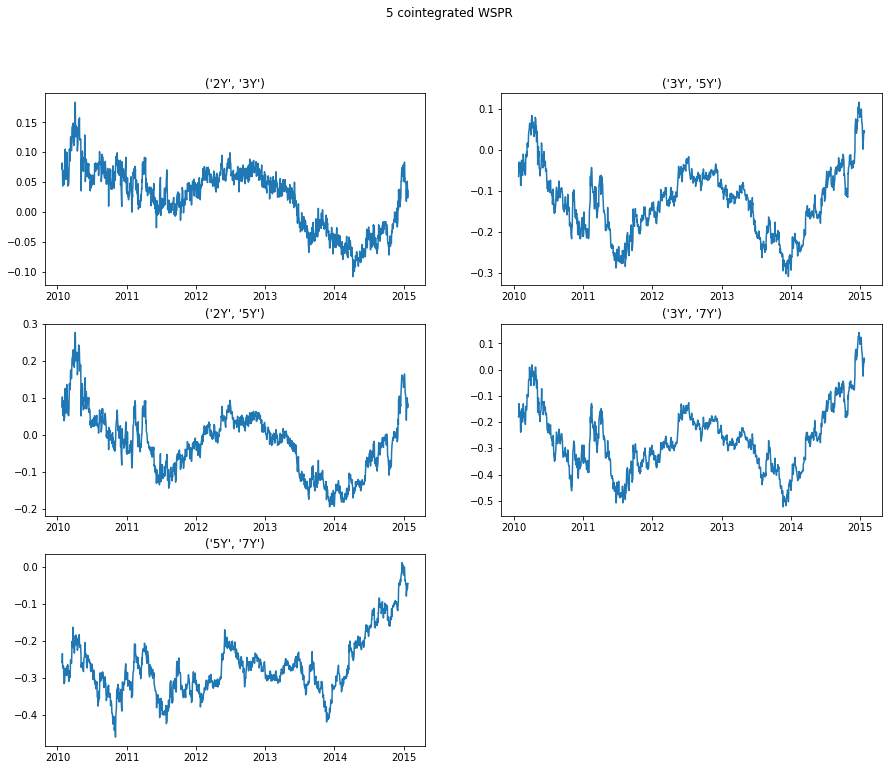

In [9]:
plot_wspr(wspr)

## 2. Construct the following:  
a. AR(1) model fitted to each of the 5 cointegrated vectors (Signal 1)  
b. AR(1) model fitted to each {cointegrated vector - EMA( )} (Signal 2)  
http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentiallyweighted-windows

In [11]:
_, wspr2 = construct_wspr(pairs, sample2)
wspr2.head()  # realized z(t)

,"('2Y', '3Y')","('3Y', '5Y')","('2Y', '5Y')","('3Y', '7Y')","('5Y', '7Y')"
Date,,,,,
2015-01-26,0.039193,0.056563,0.093891,0.059772,-0.031008
2015-01-27,0.050447,0.048819,0.100452,0.049897,-0.034045
2015-01-28,0.044210,0.043973,0.089974,0.035458,-0.047709
2015-01-29,0.037329,0.055588,0.090133,0.035084,-0.068600
2015-01-30,0.036718,0.046871,0.082935,0.015707,-0.083782


In [12]:
' Fit a few number of time series for 10 day at the same time, return 2 lists'
def fit_ar1(train_series, date=wspr2.index[0], valid_set=wspr2, forecast_day=10):
    indx = np.where(data.index==date)[0][0]
    valid = valid_set.loc[date]
    pred = pd.DataFrame(columns=train_series.columns, index=[data.index[indx+forecast_day]])
    half_life = pd.DataFrame(columns=train_series.columns, index=[date])
    
    for col in range(train_series.shape[1]):
        x = train_series.iloc[:, col]  # for training
        model = ar.AR(np.asarray(x)).fit(maxlag=1)  # AR(1)
        y = valid[col]
        pred[train_series.columns[col]] = y*model.params[1]**forecast_day + model.params[0]*(1-model.params[1]**forecast_day)/(1-model.params[1])
        half_life[train_series.columns[col]] = -np.log(2.)/np.log(model.params[1])
    
    return pred, half_life

In [13]:
# signal 1
wspr_ar1 = fit_ar1(wspr)

In [14]:
# signal 2
lbda = 0.1  # default
wspr_ewma = wspr.ewm(alpha=lbda).mean()
wspr_ewma_ar1 = fit_ar1(wspr-wspr_ewma)

## 3. Compute half-lives for all signals. Pick lambda to make sure that half-life of Signal 2 is ~5 days

In [15]:
print('Half-life of Signal 1')
print(wspr_ar1[1].T)

Half-life of Signal 1
              2015-01-26
('2Y', '3Y')   19.313070
('3Y', '5Y')   58.590796
('2Y', '5Y')   37.110572
('3Y', '7Y')   77.768706
('5Y', '7Y')   69.472717


In [16]:
print('Half-life of Signal 2 when lambda =', lbda)
print(wspr_ewma_ar1[1].T)

Half-life of Signal 2 when lambda = 0.1
              2015-01-26
('2Y', '3Y')    1.274704
('3Y', '5Y')    4.066569
('2Y', '5Y')    2.791729
('3Y', '7Y')    5.050813
('5Y', '7Y')    4.194203


In [17]:
def find_lbda(lbda, df, target_hl=5.):
    wspr_ewma = df.ewm(alpha=lbda).mean()
    wspr_ewma_ar1 = fit_ar1(df-wspr_ewma)
    hl = wspr_ewma_ar1[1].values[0][0]
    return abs(hl - target_hl)

In [18]:
signal2_lbda = wspr_ewma_ar1[1].copy()

for col in wspr.columns:
    df = pd.DataFrame(wspr[col])
    result = minimize(find_lbda, lbda, tol=1e-8, args=(df), method = 'L-BFGS-B', bounds=((0.001,0.999),))
    signal2_lbda[col] = result.x[0]
    wspr_ewma = df.ewm(alpha=result.x[0]).mean()
    hl = fit_ar1(df-wspr_ewma)[1]
    wspr_ewma_ar1[1][col] = hl

In [19]:
print('Lambdas that make Half-life of Signal 2 close to 5')
print(signal2_lbda.T)
print('Resulting Half-life')
print(wspr_ewma_ar1[1].T)

Lambdas that make Half-life of Signal 2 close to 5
              2015-01-26
('2Y', '3Y')    0.013242
('3Y', '5Y')    0.079387
('2Y', '5Y')    0.048861
('3Y', '7Y')    0.101124
('5Y', '7Y')    0.081717
Resulting Half-life
              2015-01-26
('2Y', '3Y')    5.000001
('3Y', '5Y')    5.000000
('2Y', '5Y')    5.000000
('3Y', '7Y')    5.000000
('5Y', '7Y')    5.000000


## 4. Signal 3 is a linear combination of signals 1 & 2: Signal 3= beta1 * Signal 1+ beta2 * Signal 2

## 5. Define a set of signal quality metrics, and use Validation Sample B to choose [beta1, beta2] that maximize the quality of signal metrics you chose. For simplicity, we will use all the AR(1) estimations from the Training Sample A.
a. Signal quality metrics will measure correlation between a forecast, E[z(t+H)|t], and realized z(t+H) for Signals 1,2,3 for all cointegrated pairs z(t)  
b. H=Horizon; Use H = 10 days  
c. Implement at least 2 different metrics  
d. alpha(t)=E[z(t+H)|t] - z(t), only consider |alpha(t)| > 0.25bp in your signal quality analysis  

In [79]:
'Produce signal3 given beta and signal1 and signal2'
def produce_signal(beta, col, test):
    signal3 = pd.DataFrame(index=test.index, columns=[col], dtype=np.float64)
    
    for date in test.index[:-10]:
        df = pd.DataFrame(wspr[col])
        fit1 = fit_ar1(train_series=df, date=date, valid_set=test)[0]

        wspr_ewma = df.ewm(alpha=signal2_lbda[col][0]).mean()
        fit2 = fit_ar1(train_series=df-wspr_ewma, date=date, valid_set=test)[0]

        fit3 = beta[0] * fit1 + beta[1] * fit2
        signal3.loc[fit3.index,:] = fit3.values[0]
    return signal3  # dataframe

In [129]:
'Metric1: residual least squares'
def optimize_signal_metric1(beta, col, realized, min_alpha=0.0025, test=wspr2):
    signal = produce_signal(beta, col, test)[col]
    alpha = signal.shift(-10) - realized
    criteria = alpha[abs(alpha) > min_alpha]
    realized = realized[criteria.index]
    signal = signal[criteria.index]
    return (signal[10:] - realized[10:])

'Metric2: % of time direction predict correctly'
from sklearn.metrics import accuracy_score, r2_score
def optimize_signal_metric2(beta, col, min_alpha=0.0025, test=wspr2):
    signal = produce_signal(beta, col, test)[col]
    realized = test[col]
    
    delta = realized.shift(-10) - realized  # t+10, t
    delta_hat = signal.shift(-10) - realized  # prediction: t+10, t
    
    alpha = signal.shift(-10) - realized
    criteria = alpha[abs(alpha) > min_alpha]
    delta = delta[criteria.index]
    delta_hat = delta_hat[criteria.index]

    direction = np.sign(delta)
    direction_hat = np.sign(delta_hat)
    
    metric2 = 1-accuracy_score(direction, direction_hat)
    return metric2

In [131]:
opt_metric1 = pd.DataFrame(index=wspr.columns, columns=['beta1', 'beta2'])
opt_metric2 = pd.DataFrame(index=wspr.columns, columns=['beta1', 'beta2'])

for col in wspr.columns:
    print(col, 'signal metric 1')
    realized = wspr2[col]
    result1 = least_squares(optimize_signal_metric1, np.array([0.5, 0.5]), args=(col, realized))
    opt_metric1.loc[col,:] = result1.x
    
    print(col, 'signal metric 2')
    result2 = minimize(optimize_signal_metric2, result1.x, args=(col),
                       tol=1e-2, options={'eps':1e-1}, method = 'L-BFGS-B')
    opt_metric2.loc[col,:] = result2.x

('2Y', '3Y') signal metric 1
('2Y', '3Y') signal metric 2
('3Y', '5Y') signal metric 1
('3Y', '5Y') signal metric 2
('2Y', '5Y') signal metric 1
('2Y', '5Y') signal metric 2
('3Y', '7Y') signal metric 1
('3Y', '7Y') signal metric 2
('5Y', '7Y') signal metric 1
('5Y', '7Y') signal metric 2


In [132]:
opt_metric1

,beta1,beta2
"('2Y', '3Y')",1.17216,0.934327
"('3Y', '5Y')",1.07588,0.0914056
"('2Y', '5Y')",-6.97081,29.5854
"('3Y', '7Y')",1.99962,-3.01701
"('5Y', '7Y')",3.30434,-11.2118


In [133]:
opt_metric2

,beta1,beta2
"('2Y', '3Y')",1.17216,0.934327
"('3Y', '5Y')",1.10466,0.129791
"('2Y', '5Y')",-6.81926,29.8757
"('3Y', '7Y')",1.99779,-3.01751
"('5Y', '7Y')",3.31094,-11.1338


## 6. Run your signal quality analysis using a testing sample C. Break the test sample into 4 quarters, and see how your results evolve from quarter to quarter. Analyze all results.

In [58]:
sample3_split = np.array_split(sample3, 4)

In [134]:
sample3_result = pd.DataFrame(index=range(4), columns=opt_metric2.index)

for i in range(4):
    _, wspr3 = construct_wspr(pairs, sample3_split[i])
    for col in opt_metric2.index:
        beta = opt_metric2.loc[col].values
        sample3_result.loc[i,col] = 1 - optimize_signal_metric2(beta, col, test=wspr3)

In [146]:
sample3_result

,"('2Y', '3Y')","('3Y', '5Y')","('2Y', '5Y')","('3Y', '7Y')","('5Y', '7Y')"
0,0.490566,0.566038,0.528302,0.566038,0.666667
1,0.490566,0.471698,0.490566,0.471698,0.62
2,0.622642,0.660377,0.716981,0.716981,0.68
3,0.660377,0.735849,0.735849,0.782609,0.66


In [147]:
sample3_result.mean(1)

0    0.563522
1    0.508906
2    0.679396
3    0.714937
dtype: float64

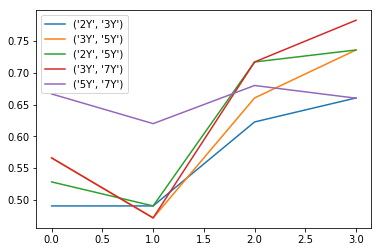

In [136]:
sample3_result.plot()

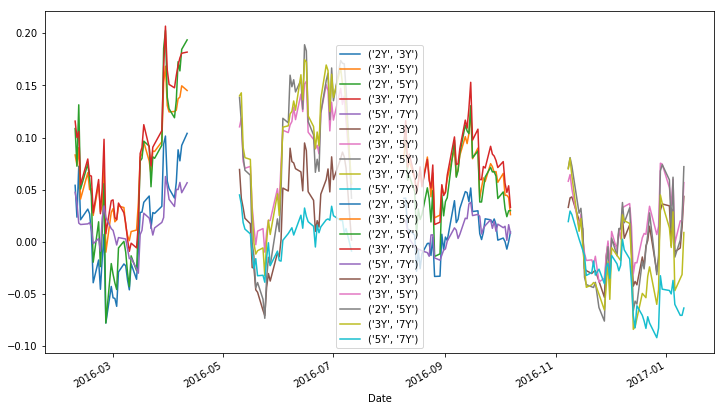

In [142]:
plt.figure(figsize=(12,7))
for i in range(4):
    _, wspr3 = construct_wspr(pairs, sample3_split[i])
    for col in opt_metric1.index:
        beta = opt_metric1.loc[col].values
        realized = wspr3[col]
        optimize_signal_metric1(beta, col, realized, test=wspr3).plot()
plt.legend()

## Conclusion
I designed two signal quality metrics:  
(1) residual least squares of forecast(signal3) and realized  
(2) accuracy of 10-day direction of forecast(signal3) and realized  
Through validation using sample2, I get optimized beta for construction of signal3. Optimized beta using two metrics produce very similar results. Then I used optimized beta to test on signals for sample3, which is splitted into 4 quarters.  
We can see from charts and plots that fourth quarter is the best quarter of prediction with smallest residual least squares around 0 and greatest accuracy score around 71% averaged among all pairs, and second quarter is the worst quarter with largest residual least squares and smallest accuracy score(51%).